Two-channel results:\
1. wc1 = 0.6 (20km); bc1 = 0.6; bc2 = 0.4; to explore how does Q1 adjust with w2 (ex7)
2. wc1 = 0.6 (20km); wc2 = 1.2 (40km); bc1 = 0.6; to explore how does Q1 adjust with b2 (ex9)

In [1]:
# %matplotlib notebook
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sp
import matplotlib.pyplot as plt
import scipy.io as sio
import os

from dask.diagnostics import ProgressBar
from matplotlib import cm

In [2]:
def Two_model(w1m, w2m, b1m, b2m, ds, Exnum):
    import glob
    
    # Compute scales for nondimensional variables
    r = 6.371e+6
    unit = 2*np.pi*r/360
    Omega = 7.292e-5
    g = 4e-4
    Di = 1000
    lat = -8
    q = -1
    f0 = abs(2*Omega*np.sin(lat/180*np.pi))
    beta = 2*Omega*np.cos(lat/180*np.pi)/r
    Ld = np.sqrt(g*Di)/f0
    D = -q*Di

    r1m = (np.power((np.array(w1m)/2.0), 2)/ds).tolist()
    r2m = (np.power((np.array(w2m)/2.0), 2)/ds).tolist()

    # model results
    infilepath = '/Users/tantanmeow/Desktop/WORK/MODEL/Onelayer/try5/Par_2_allofthem/'
    filename_ = np.sort(glob.glob(os.path.join(infilepath + 'Out_' +str(Exnum) + "*")))
    Q1m = np.zeros(filename_.shape) + np.nan
    Q2m = np.zeros(filename_.shape) + np.nan
    for i in range(len(filename_)):
        Data = xr.open_dataset(filename_[i])
        Q1m[i] = np.mean(Data.Q_c1[np.where(Data.time >= 250)]).data
        Q2m[i] = np.mean(Data.Q_c2[np.where(Data.time >= 250)]).data

    # theory results
    Gill_path = '../data/'# path to Gill's prediction
    if np.array(w1m).size>1:
        Gill_name = 'Gill_parabolic_nd_2channel_w2.mat'# Gill_name = 'Gill_predict.mat'
        data = sio.loadmat(Gill_path + Gill_name,squeeze_me = True,struct_as_record = False)
        Q1s = data['Q1'] 
        Q2s = data['Q2'] 
        w1s = data['wc_w'] 
        w2s = data['wc_e'] 
        r1s = data['rc_w'] 
        r2s = data['rc_e'] 
        # numpy.array to xarray.DataArray
        w1m = xr.DataArray(w1m, [('r2m', r2m)]) 
        r1m = xr.DataArray(r1m, [('r2m', r2m)])   
        w2m = xr.DataArray(w2m, [('r2m', r2m)])   
        Q1m = xr.DataArray(Q1m, [('r2m', r2m)])   
        Q2m = xr.DataArray(Q2m, [('r2m', r2m)])     
        w1s = xr.DataArray(w1s, [('r1s', r1s)]) 
        w2s = xr.DataArray(w2s, [('r2s', r2s)])         
        Q1s = xr.DataArray(Q1s, [('r1s', r1s), ('r2s', r2s)])  
        Q2s = xr.DataArray(Q2s, [('r1s', r1s), ('r2s', r2s)])  
        # build Dataset
        Data_2channel = xr.Dataset({'w1m': (['r2m'], w1m),
                                'r1m': (['r2m'], r1m),
                                'w2m': (['r2m'], w2m),
                                'Q1m': (['r2m'], Q1m),
                                'Q2m': (['r2m'], Q2m),
                                'w1s': (['r1s'], w1s),
                                'w2s': (['r2s'], w2s),
                                'Q1s': (['r1s', 'r2s'], Q1s),
                                'Q2s': (['r1s', 'r2s'], Q2s)},
                               coords={'r2m': r2m,
                                       'r1s': r1s,
                                       'r2s': r2s},
                               attrs={'title': 'Q from model and theory',
                                      'description': '2-channel case, varying w2'})       
    else:
        Gill_name = 'Gill_parabolic_nd_2channel_b2.mat'   
        data = sio.loadmat(Gill_path + Gill_name,squeeze_me = True,struct_as_record = False)
        Q1s = data['Q1'] 
        Q2s = data['Q2'] 
        b1s = data['bc_w'] 
        b2s = data['bc_e'] 
        rs = data['rc'] 
        ws = data['wc'] 
        # numpy.array to xarray.DataArray
        b1m = xr.DataArray(b1m, [('b2m', b2m)])  
        Q1m = xr.DataArray(Q1m, [('b2m', b2m)])   
        Q2m = xr.DataArray(Q2m, [('b2m', b2m)])            
        Q1s = xr.DataArray(Q1s, [('b1s', b1s), ('b2s', b2s)])  
        Q2s = xr.DataArray(Q2s, [('b1s', b1s), ('b2s', b2s)]) 
        # build Dataset
        Data_2channel = xr.Dataset({'b1m': (['b2m'], b1m),
                                'Q1m': (['b2m'], Q1m),
                                'Q2m': (['b2m'], Q2m),
                                'Q1s': (['b1s', 'b2s'], Q1s),
                                'Q2s': (['b1s', 'b2s'], Q2s)},
                               coords={'b2m': b2m,
                                       'b1s': b1s,
                                       'b2s': b2s},
                               attrs={'title': 'Q from model and theory',
                                      'description': '2-channel case, varying b2'})       
 
    return Data_2channel, data['D'], data['H'], data['V'], data['X0']

In [3]:
# ex7
b1m = .6
b2m = .4
ds = .5
w1m = [.6, .6, .6, .6, .6, .6, .6, .6]
w2m = [.4, .8, 1.2, 1.6, .6, 1.0, 1.4, 1.8]

Data_ex7, D_ex7, H_ex7, V_ex7, X0_ex7 = Two_model(w1m, w2m, b1m, b2m, ds, 7)

In [4]:
def find_nearest(array, value):
    """ Find the nearest point of
        code stolen from https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx


def extract_data(Data):
    """ Extract and regulate data from xarray Dataset. (x, y) - (east, north)"""
    # ragulate data
    t = Data.time.data
    d = Data.H.data
    v = Data.U.data  # northward
    u = Data.V.data  # westward
    h = Data.B.data
    # dims=['time', 'y', 'x']
    # (y, x) is in fact (west, north) convert to (x, y) or (east, north)
    u = -u[:, ::-1, :]  # now the flow speed is toward east
    v = v[:, ::-1, :]
    d = d[:, ::-1, :]
    h = h[::-1, :]
    x = Data.y.data
    y = Data.x.data
    return x, y, t, d, h, v, u


def build_data(x,y,t,d,h,v,u):
    """ Build xarray Dataset. (x, y) - (east, north)"""
    # build DataArray
    B = xr.DataArray(h, dims=['x', 'y'], 
                    coords={'x': x, 
                            'y': y},
                    attrs={'long_name':'Bottom Elevation'})
    H = xr.DataArray(d, dims=['time', 'x', 'y'], 
                    coords={'time':t, 
                            'x': x, 
                            'y': y},
                    attrs={'long_name':'Layer Thickness'})
    U = xr.DataArray(u, dims=['time', 'x', 'y'], 
                    coords={'time':t, 
                            'x': x, 
                            'y': y},
                    attrs={'long_name':'Eastward Velocity'})
    V = xr.DataArray(v, dims=['time', 'x', 'y'], 
                    coords={'time':t, 
                            'x': x, 
                            'y': y},
                    attrs={'long_name':'Northward Velocity'})    
    
    # build Dataset
    data = xr.Dataset({'B': (['x', 'y'], B),
                       'H': (['time', 'x', 'y'], H),
                       'U': (['time', 'x', 'y'], U),
                       'V': (['time', 'x', 'y'], V)},
                     coords={'time': t,
                            'x': x, 
                            'y': y},
                     attrs={'title':'Outputs from nondimensional model',
                           'description':'Scales: H~1000 m; L~30 km; T~0.6 d; x -'})
    return data

In [5]:
# model results
import glob
infilepath = '/Users/tantanmeow/Desktop/WORK/MODEL/Onelayer/try5/Par_2_allofthem/'
filename_ = np.sort(glob.glob(os.path.join(infilepath + 'Out_7' + "*")))
Q1m = np.zeros(filename_.shape) + np.nan
Q2m = np.zeros(filename_.shape) + np.nan

_, idx = find_nearest(w2m, 1.2)
Data = xr.open_dataset(filename_[idx])

infilepath = '/Users/tantanmeow/Desktop/WORK/MODEL/Onelayer/try5/Par_2_allofthem/'
filename_ = np.sort(glob.glob(os.path.join(infilepath + 'Data_7' + "*")))
Data_all = xr.open_dataset(filename_[idx])

# make coordinates correct: v/y means north-south, u/x means west-east and rebuild dataset
x, y, t, d, h, v, u = extract_data(Data_all)
v[d < 1e-7] = np.nan
d[d < 1e-7] = np.nan
Data_all = build_data(x,y,t,d,h,v,u) 

In [6]:
# ex9
ds = .5
w1m = 0.6
w2m = 1.2
b1m = [.6, .6, .6, .6, .6, .6]
b2m = [0, .2, .4, .6, .8, 1.0]

Data_ex9, D_ex9, H_ex9, V_ex9, X0_ex9 = Two_model(w1m, w2m, b1m, b2m, ds, 9)

In [7]:
ds = .5
def r2w(x):
    return 2 * (x * ds)**.5
def w2r(x):
    return (x/2)**2/ds

print(w2r(Data_ex7.w1s[Data_ex7.w1s == Data_ex7.w1m[0]].data), w2r(Data_ex7.w2s[Data_ex7.w2s == Data_ex7.w2m[idx]].data))
print(.6, .4)

[0.18] [0.72]
0.6 0.4


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

theory prediction (nondimensional): [0.16844459] [0.28192623] [0.45037083]
theory prediction (dimensional Sv): [3.319595] [5.55601645] [8.87561146]
model mean (nondimensional): 0.12790650726176472 0.2555354906360278 0.38344199789779254
model mean (dimensional Sv): 2.5206971567359338 5.035925055580867 7.5566222123168005


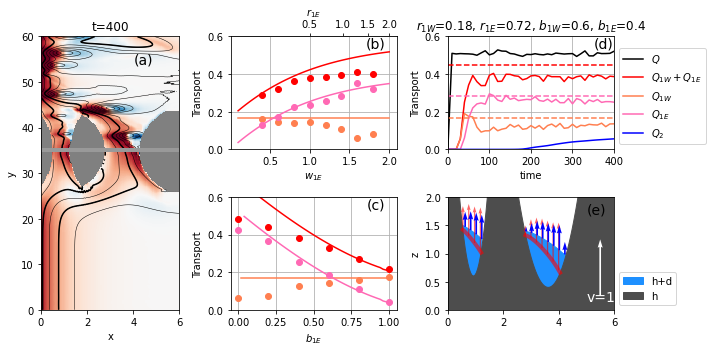

In [8]:
# Compute scales for nondimensional variables
r = 6.371e+6
unit = 2*np.pi*r/360
Omega = 7.292e-5
g = 4e-4
Di = 1000
lat = -8
q = -1
f0 = abs(2*Omega*np.sin(lat/180*np.pi))
beta = 2*Omega*np.cos(lat/180*np.pi)/r
Ld = np.sqrt(g*Di)/f0
D = -q*Di

from matplotlib import gridspec
from matplotlib import cm
cmap=cm.RdBu_r
cmap.set_bad('gray',1.)

fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1.2, 1.2])

ax0 = plt.subplot(gs[:,0])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[1,1])
ax7 = plt.subplot(gs[0,-1])
ax8 = plt.subplot(gs[1,-1])

Data_all.V.sel(time=400, method='nearest').T.plot(cmap=cmap, vmin=-0.5, vmax=0.5, add_colorbar=False, ax=ax0)
(Data_all.H.sel(time=400, method='nearest')+Data_all.B).T.plot.contour(levels=np.arange(0, 2+1e-4, 0.1, dtype=float), colors='k', linewidths=.5, add_colorbar=False, ax=ax0)
(Data_all.H.sel(time=400, method='nearest')+Data_all.B).T.plot.contour(levels=[1.2, 1.4], colors='k', add_colorbar=False, ax=ax0)
ax0.plot([0, 10], [35, 35], color='0.6', lw=4)
ax0.set_title('t=400')
ax0.set_xlim([0, 6])
ax0.set_ylim([0, 60])
ax0.set_xticks(np.around(np.arange(0, 6+1e-4, step=2),0))
ax0.text(4, 54, '(a)', fontsize=14, color='black')

Data.Q_u.plot(c='k', label='$Q$', ax=ax7)
(Data.Q_c1+Data.Q_c2).plot(c='r', label='$Q_{1W}+Q_{1E}$', ax=ax7)
Data.Q_c1.plot(c='coral', label='$Q_{1W}$', ax=ax7)
Data.Q_c2.plot(c='hotpink', label='$Q_{1E}$', ax=ax7)
Data.Q_p.plot(c='b', label='$Q_2$', ax=ax7)
ax7.plot([0, 400], [Data_ex7.Q1s[Data_ex7.w1s == Data_ex7.w1m[0], Data_ex7.w2s == Data_ex7.w2m[idx]].data.flatten(), 
                    Data_ex7.Q1s[Data_ex7.w1s == Data_ex7.w1m[0], Data_ex7.w2s == Data_ex7.w2m[idx]].data.flatten()], c='coral', linestyle='dashed')
ax7.plot([0, 400], [Data_ex7.Q2s[Data_ex7.w1s == Data_ex7.w1m[0], Data_ex7.w2s == Data_ex7.w2m[idx]].data.flatten(),
                    Data_ex7.Q2s[Data_ex7.w1s == Data_ex7.w1m[0], Data_ex7.w2s == Data_ex7.w2m[idx]].data.flatten()], c='hotpink', linestyle='dashed')
ax7.plot([0, 400], [Data_ex7.Q1s[Data_ex7.w1s == Data_ex7.w1m[0], Data_ex7.w2s == Data_ex7.w2m[idx]].data.flatten()+Data_ex7.Q2s[Data_ex7.w1s == Data_ex7.w1m[0], Data_ex7.w2s == Data_ex7.w2m[idx]].data.flatten(),
                    Data_ex7.Q1s[Data_ex7.w1s == Data_ex7.w1m[0], Data_ex7.w2s == Data_ex7.w2m[idx]].data.flatten()+Data_ex7.Q2s[Data_ex7.w1s == Data_ex7.w1m[0], Data_ex7.w2s == Data_ex7.w2m[idx]].data.flatten()], c='r', linestyle='dashed')
ax7.set_xlim(0, 400)
ax7.set_ylim(0, 0.6)
ax7.set_title('$r_{1W}$=0.18, $r_{1E}$=0.72, $b_{1W}$=0.6, $b_{1E}$=0.4')
ax7.grid(True)
ax7.legend(bbox_to_anchor=(1,0), loc='lower left', fontsize=10)
ax7.text(350, .54, '(d)', fontsize=14, color='k')
ax7.set_ylabel('Transport')

yc = 35
from scipy.signal import find_peaks
peaks, _ = find_peaks(-Data_all.B.sel(y=yc, method='nearest'))
xc1 = Data_all.x[peaks].data[0]
xc2 = Data_all.x[peaks].data[1]
h1 = H_ex7[0,:,Data_ex7.w1s==Data_ex7.w1m[0], Data_ex7.w2s == Data_ex7.w2m[idx]].squeeze()
d1 = D_ex7[0,:,Data_ex7.w1s==Data_ex7.w1m[0], Data_ex7.w2s == Data_ex7.w2m[idx]].squeeze()
v1 = V_ex7[0,:,Data_ex7.w1s==Data_ex7.w1m[0], Data_ex7.w2s == Data_ex7.w2m[idx]].squeeze()
x1 = X0_ex7[0,:,Data_ex7.w1s==Data_ex7.w1m[0], Data_ex7.w2s == Data_ex7.w2m[idx]].squeeze()
x1 = x1 - x1[np.where(h1 == min(h1))] + xc1
h2 = H_ex7[1,:,Data_ex7.w1s==Data_ex7.w1m[0], Data_ex7.w2s == Data_ex7.w2m[idx]].squeeze()
d2 = D_ex7[1,:,Data_ex7.w1s==Data_ex7.w1m[0], Data_ex7.w2s == Data_ex7.w2m[idx]].squeeze()
v2 = V_ex7[1,:,Data_ex7.w1s==Data_ex7.w1m[0], Data_ex7.w2s == Data_ex7.w2m[idx]].squeeze()
x2 = X0_ex7[1,:,Data_ex7.w1s==Data_ex7.w1m[0], Data_ex7.w2s == Data_ex7.w2m[idx]].squeeze()
x2 = x2 - x2[np.where(h2 == min(h2))] + xc2
ax8.fill_between(Data_all.x, Data_all.H.sel(time=400, y=yc, method='nearest') + Data_all.B.sel(y=yc, method='nearest'), 0, color='dodgerblue', label='h+d')
ax8.fill_between(Data_all.x, Data_all.B.sel(y=yc, method='nearest'), 0, color='0.3', label='h')
ax8.set_xlim([0, 6])
ax8.set_ylim([0, 2])
ax8.set_ylabel('z')
ax8.legend(bbox_to_anchor=(1,0), loc='lower left', fontsize=10)
ax8.plot(x1, h1+d1, color='r', lw=4, alpha=0.6, label='h+d (theory)')
ax8.plot(x2, h2+d2, color='r', lw=4, alpha=0.6, label='h+d (theory)')
# v, model at t=400
ax8.quiver(x1[::16], h1[::16]+d1[::16], 0, v1[::16],
          scale=1, scale_units='y', lw=4, color='r', alpha=0.6)
ax8.quiver(x2[::8], h2[::8]+d2[::8], 0, v2[::8],
          scale=1, scale_units='y', lw=4, color='r', alpha=0.6)
ax8.quiver(Data_all.x.data[::4], (Data_all.H.sel(time=400, y=yc, method='nearest') + Data_all.B.sel(y=yc, method='nearest')).data[::4], 0, Data_all.V.sel(time=400, y=yc, method='nearest')[::4].data,
          scale=1, scale_units='y', width= 0.01, color='b')
ax8.quiver(5.5, 0.25, 0, 1,
          scale=1, scale_units='y', width= 0.01, color='w')
ax8.text(5, 0.15, 'v=1', fontsize=14, color='w')
ax8.text(5, 1.7, '(e)', fontsize=14, color='black')

ax1.plot(Data_ex7.w2s.data, Data_ex7.Q1s[Data_ex7.w1s==Data_ex7.w1m[0],:].squeeze().data, c='coral')
ax1.plot(Data_ex7.w2m.data, Data_ex7.Q1m.squeeze().data, c='coral', marker='o',linestyle = 'None')
ax1.plot(Data_ex7.w2s.data, Data_ex7.Q2s[Data_ex7.w1s==Data_ex7.w1m[0],:].squeeze().data, c='hotpink')
ax1.plot(Data_ex7.w2m.data, Data_ex7.Q2m.squeeze().data, c='hotpink', marker='o',linestyle = 'None')
ax1.plot(Data_ex7.w2s.data, Data_ex7.Q1s[Data_ex7.w1s==Data_ex7.w1m[0],:].squeeze().data + Data_ex7.Q2s[Data_ex7.w1s==Data_ex7.w1m[0],:].squeeze().data, c='r')
ax1.plot(Data_ex7.w2m.data, Data_ex7.Q1m.squeeze().data + Data_ex7.Q2m.squeeze().data, c='r', marker='o',linestyle = 'None')
secax = ax1.secondary_xaxis('top', functions=(w2r,r2w))
secax.set_xlabel('$r_{1E}$')
ax1.set_xlabel('$w_{1E}$')
ax1.set_ylabel('Transport')
ax1.set_ylim(0,.6)
ax1.grid(True)
ax1.text(1.7, .54, '(b)', fontsize=14, color='black')

ax2.plot(Data_ex9.b2s.data, Data_ex9.Q1s[Data_ex9.b1s==Data_ex9.b1m[0],:].squeeze().data, c='coral')
ax2.plot(Data_ex9.b2m.data, Data_ex9.Q1m.squeeze().data, c='coral', marker='o',linestyle = 'None')
ax2.plot(Data_ex9.b2s.data, Data_ex9.Q2s[Data_ex9.b1s==Data_ex9.b1m[0],:].squeeze().data, c='hotpink')
ax2.plot(Data_ex9.b2m.data, Data_ex9.Q2m.squeeze().data, c='hotpink', marker='o',linestyle = 'None')
ax2.plot(Data_ex9.b2s.data, Data_ex9.Q1s[Data_ex9.b1s==Data_ex9.b1m[0],:].squeeze().data + Data_ex9.Q2s[Data_ex9.b1s==Data_ex9.b1m[0],:].squeeze().data, c='r')
ax2.plot(Data_ex9.b2m.data, Data_ex9.Q1m.squeeze().data + Data_ex9.Q2m.squeeze().data, c='r', marker='o',linestyle = 'None')
ax2.set_xlabel('$b_{1E}$')
ax2.set_ylabel('Transport')
ax2.set_ylim(0,.6)
ax2.grid(True)
ax2.text(.85, .54, '(c)', fontsize=14, color='black')


plt.tight_layout()
plt.savefig('../pics/Fig13.jpg', dpi=300)
plt.savefig('../pics/Fig13.tif', dpi=300)
plt.savefig('../pics/Fig13.eps')
print('theory prediction (nondimensional):', Data_ex7.Q1s[Data_ex7.w1s == Data_ex7.w1m[0], Data_ex7.w2s == Data_ex7.w2m[idx]].data.flatten(), Data_ex7.Q2s[Data_ex7.w1s == Data_ex7.w1m[0], Data_ex7.w2s == Data_ex7.w2m[idx]].data.flatten(), Data_ex7.Q1s[Data_ex7.w1s == Data_ex7.w1m[0], Data_ex7.w2s == Data_ex7.w2m[idx]].data.flatten()+Data_ex7.Q2s[Data_ex7.w1s == Data_ex7.w1m[0], Data_ex7.w2s == Data_ex7.w2m[idx]].data.flatten())
scaler = f0/g/Di/Di
print('theory prediction (dimensional Sv):', Data_ex7.Q1s[Data_ex7.w1s == Data_ex7.w1m[0], Data_ex7.w2s == Data_ex7.w2m[idx]].data.flatten()/scaler*1e-6, Data_ex7.Q2s[Data_ex7.w1s == Data_ex7.w1m[0], Data_ex7.w2s == Data_ex7.w2m[idx]].data.flatten()/scaler*1e-6, Data_ex7.Q1s[Data_ex7.w1s == Data_ex7.w1m[0], Data_ex7.w2s == Data_ex7.w2m[idx]].data.flatten()/scaler*1e-6+Data_ex7.Q2s[Data_ex7.w1s == Data_ex7.w1m[0], Data_ex7.w2s == Data_ex7.w2m[idx]].data.flatten()/scaler*1e-6)

print('model mean (nondimensional):', Data.Q_c1[Data.time >= 250].mean().data, Data.Q_c2[Data.time >= 250].mean().data, Data.Q_c1[Data.time >= 250].mean().data+Data.Q_c2[Data.time >= 250].mean().data)
scaler = f0/g/Di/Di
print('model mean (dimensional Sv):', Data.Q_c1[Data.time >= 250].mean().data/scaler*1e-6, Data.Q_c2[Data.time >= 250].mean().data/scaler*1e-6, Data.Q_c1[Data.time >= 250].mean().data/scaler*1e-6+Data.Q_c2[Data.time >= 250].mean().data/scaler*1e-6)
